In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [2]:
#!pip install tensorflow==2.5.0

In [3]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [4]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [5]:
# Sunspots.csv
!gdown --id 1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5

Downloading...
From: https://drive.google.com/uc?id=1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5
To: /content/Sunspots.csv
100% 70.8k/70.8k [00:00<00:00, 26.8MB/s]


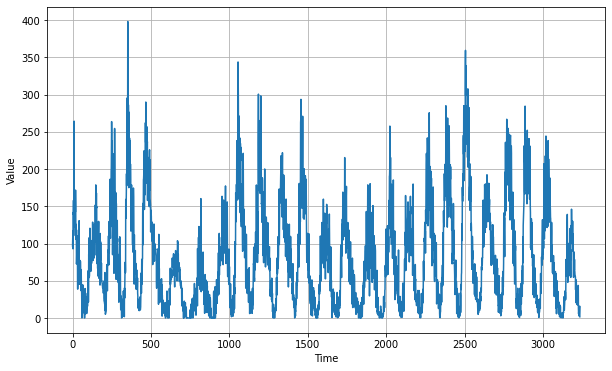

In [6]:
import csv
time_step = []
sunspots = []

with open('./Sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

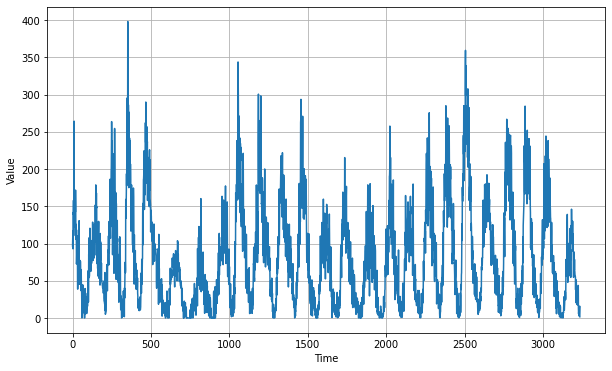

In [7]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [8]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [10]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 34s 55ms/step - loss: 79.8340 - mae: 80.3314
Epoch 2/100
12/12 [==============================] - 1s 54ms/step - loss: 78.0944 - mae: 78.5918
Epoch 3/100
12/12 [==============================] - 1s 54ms/step - loss: 75.4519 - mae: 75.9497
Epoch 4/100
12/12 [==============================] - 1s 54ms/step - loss: 72.2679 - mae: 72.7658
Epoch 5/100
12/12 [==============================] - 1s 53ms/step - loss: 68.7693 - mae: 69.2672
Epoch 6/100
12/12 [==============================] - 1s 55ms/step - loss: 65.1128 - mae: 65.6099
Epoch 7/100
12/12 [==============================] - 1s 58ms/step - loss: 61.5272 - mae: 62.0241
Epoch 8/100
12/12 [==============================] - 1s 55ms/step - loss: 58.1406 - mae: 58.6369
Epoch 9/100
12/12 [==============================] - 1s 55ms/step - loss: 55.0732 - mae: 55.5697
Epoch 10/100
12/12 [====

(1e-08, 0.0001, 0.0, 60.0)

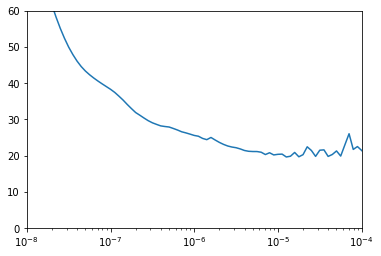

In [12]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 5s 37ms/step - loss: 38.9198 - mae: 39.4161
Epoch 2/500
30/30 [==============================] - 1s 36ms/step - loss: 25.7735 - mae: 26.2680
Epoch 3/500
30/30 [==============================] - 1s 35ms/step - loss: 22.0760 - mae: 22.5697
Epoch 4/500
30/30 [==============================] - 1s 36ms/step - loss: 20.4729 - mae: 20.9658
Epoch 5/500
30/30 [==============================] - 1s 36ms/step - loss: 19.7634 - mae: 20.2558
Epoch 6/500
30/30 [==============================] - 1s 35ms/step - loss: 19.3055 - mae: 19.7977
Epoch 7/500
30/30 [==============================] - 1s 35ms/step - loss: 18.7278 - mae: 19.2200
Epoch 8/500
30/30 [==============================] - 1s 35ms/step - loss: 18.1150 - mae: 18.6066
Epoch 9/500
30/30 [==============================] - 1s 36ms/step - loss: 18.0975 - mae: 18.5892
Epoch 10/500
30/30 [==============================] - 1s 35ms/step - loss: 19.9061 - mae: 20.3985
Epoch 11/500
30/30 [=========

In [14]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

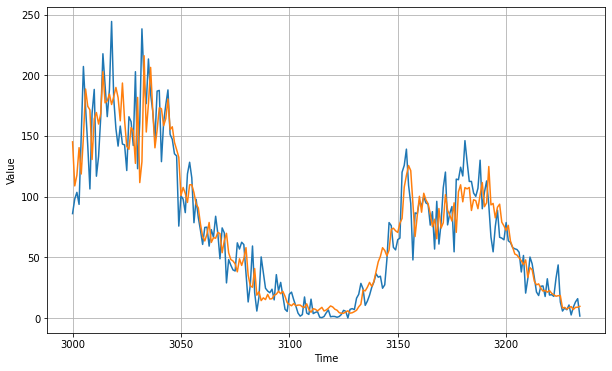

In [15]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [16]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

14.934442

<Figure size 432x288 with 0 Axes>

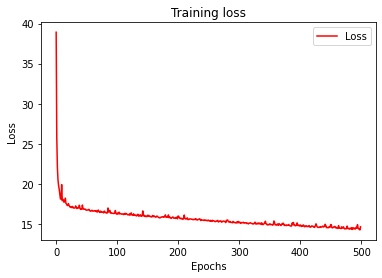

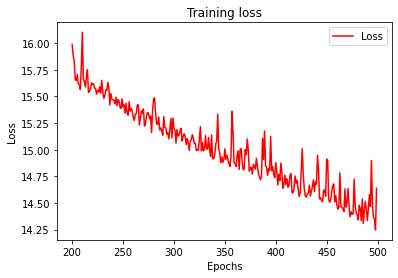

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [18]:
print(rnn_forecast)

[145.10567   108.82158   117.74873   140.32643   118.623474  148.82437
 188.63776   174.44199   171.48294   130.58337   164.09436   169.25754
 159.78102   168.52695   202.89812   177.24144   179.02394   184.4728
 175.87769   182.34628   189.94647   181.60626   162.43259   193.57916
 162.66092   141.36699   139.01042   156.88458   154.2535    127.38389
 181.70268   111.56175   128.73335   216.06955   153.21312   176.48944
 206.44414   170.3709    140.19635   154.85483   173.14227   172.45503
 158.42102   164.18735   180.39194   155.21602   157.52893   144.74379
 138.73337   132.3838    100.76677   107.55117   102.61289    95.19265
 109.68704   109.82028   103.25637    93.72065    90.77718    77.33443
  67.2052     63.464664   69.12079    78.69275    62.26027    66.14647
  65.6989     70.4436     69.593475   53.77791    63.663704   69.75102
  53.717876   48.145657   46.97341    44.5355     38.034515   48.74081
  43.30157    49.002926   57.948875   35.21655    26.57237    25.283962
  40.7